# Indeed Job Level Classifier Challenge - predict partially labelled dataset


Code from: https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX und
 https://mccormickml.com/2019/07/22/BERT-fine-tuning/

**1. Check GPU and Import Data** ================================================================================================================

In [69]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Dec 23 17:08:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import Libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import os
import regex as re
import io
pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We load in both the challenge data.json as well as our scraped indeed dataset with the short and the one with the long summaries.

In [71]:
path = '/content/drive/My Drive/Colab Notebooks/clf/data.json'
df_val_pred = pd.read_json(path)
df_val_pred.head(2)

,level,description,title
0,Entry Level,OUTFITTERY is Europe’s biggest Personal Shoppi...,Frontend Engineer (m/f)
1,Senior Level,OUTFITTERY is Europe’s biggest Personal Shoppi...,Senior Product Manager (m/f)


In [72]:
path = '/content/drive/My Drive/Colab Notebooks/clf/df_all_small_sum.csv'
df_root = pd.read_csv(path)
df_root = df_root[["title", "summary", "level"]]
df_root.head(2)

,title,summary,level
0,newTHE LATE SHOW WITH STEPHEN COLBERT - SUMMER...,"Our program provides college juniors, seniors,...",internship
1,newIntern *,Gain industry and organizational knowledge thr...,internship


In [73]:
path = '/content/drive/My Drive/Colab Notebooks/clf/df_all_big_sum.csv'
df_root_big = pd.read_csv(path)
df_root_big = df_root_big[["title", "description", "level"]]
df_root_big.head(2)

,title,description,level
0,Live-in Caregiver Weekly Pay,Earn a $100 Signing Bonus! Schedule is for liv...,entry_level
1,Warehouse Package Handler,"IMMEDIATE OPENINGS!\nNow Hiring in Knightdale,...",entry_level


**2. Clean Data** ================================================================================================================

Usually it is not advisable to look at the test data before the training to avoid possible bias. We will therefore only look at some basic aspects, then do our train test split and then do a deeper analysis of the trainingset. We only need some of columns of the indeed dataset to create our training- and testset. 

In [75]:
df = df_root[["title", "summary", "level"]].copy()
df = df.rename({"summary": "description"}, axis=1) 
df.head(1)

,title,description,level
0,newTHE LATE SHOW WITH STEPHEN COLBERT - SUMMER...,"Our program provides college juniors, seniors,...",internship


In [76]:
df_big = df_root_big[["title", "description", "level"]].copy()
df_big.head(1)

,title,description,level
0,Live-in Caregiver Weekly Pay,Earn a $100 Signing Bonus! Schedule is for liv...,entry_level


We can do some basic cleaning. In the indeed dataset we can take out the "new" at the beginng of the titles since we do not really care if the job advert is recent or older. Furthermore we can get clean the text a bit and make everything lowercased. (We will use BERT in lowercase mode anyways, from personal experience it performs better then in the cased mode).

In [78]:
def df_clean(df):
  try:
    df["title"] = df["title"].str[:3].str.replace("new", "", case=True) + df["title"].str[3:]
    df["title"] = df["title"].str.lower()
    df["description"] = df["description"].str.lower()
    df["description"] = df["description"].str.replace("\n", " ")
    df["level"] = df["level"].str.lower()
    df["level"] = df["level"].str.replace("_", " ")
  except: print("check columns")
  return df

In [79]:
df = df_clean(df)
df.head(1)

,title,description,level
0,the late show with stephen colbert - summer 20...,"our program provides college juniors, seniors,...",internship


In [80]:
df_big = df_clean(df_big)
df_big.head(1)

,title,description,level
0,live-in caregiver weekly pay,earn a $100 signing bonus! schedule is for liv...,entry level


Let's take a quick look at the challenge dataset first. As it turns out, not all of the text is in English. We use deepl.com to translate the descriptions. langdetect also falsely detects languages, however, we do find a few examples, where the text is in German and French

In [81]:
df_val_pred = df_clean(df_val_pred)
df_val_pred.head(3)

,level,description,title
0,entry level,outfittery is europe’s biggest personal shoppi...,frontend engineer (m/f)
1,senior level,outfittery is europe’s biggest personal shoppi...,senior product manager (m/f)
2,entry level,job description pamet is looking for android d...,android developer


In [82]:
!pip install langdetect

In [83]:
from langdetect import detect
df_val_pred['lang_description'] = df_val_pred['description'].apply(detect)
df_val_pred['lang_title'] = df_val_pred['title'].apply(detect)

In [84]:
df_val_pred.lang_description.value_counts()

en    210
fr      3
tl      2
nl      1
Name: lang_description, dtype: int64

In [85]:
df_val_pred[df_val_pred.lang_description == "tl"]   

,level,description,title,lang_description,lang_title
146,NaN,no,praktikant im bereich operations & customer se...,tl,en
153,NaN,no,werkstudent promotion,tl,en


In [86]:
df_val_pred.lang_title.value_counts()

en    122
fr     22
da     15
nl     13
it     11
af     10
es      6
ro      4
ca      3
de      3
sv      2
so      1
hr      1
sl      1
no      1
tl      1
Name: lang_title, dtype: int64

In [87]:
df_val_pred[df_val_pred.lang_title == "de"] 

,level,description,title,lang_description,lang_title
27,mid level,no description available.,software engineer - back-end,fr,de
28,entry level,over 2 million business owners use yelp to con...,"software engineer - backend (hamburg, de)",en,de
192,NaN,we are a growing software company with a nitch...,web designer,en,de


Trying around a bit, we find 3 non-English entries:

In [88]:
#translate this:
df_val_pred.iloc[[146, 153, 166]]

,level,description,title,lang_description,lang_title
146,NaN,no,praktikant im bereich operations & customer se...,tl,en
153,NaN,no,werkstudent promotion,tl,en
166,NaN,teads.tv est spécialisé dans la diffusion de c...,finance controller,fr,it


In [89]:
!pip install deepl

We use the Deepl API to translate these:

In [90]:
import deepl
auth_key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
translator = deepl.Translator(auth_key)

In [91]:
string_to_translate = df_val_pred.iloc[146]["title"]
string_to_translate = string_to_translate.replace("\n", " ").replace("  ", " ").strip()
result_new = str(translator.translate_text(string_to_translate, target_lang="EN-US"))
df_val_pred.loc[146, "title"] = result_new

In [92]:
string_to_translate = df_val_pred.iloc[153]["title"]
string_to_translate = string_to_translate.replace("\n", " ").replace("  ", " ").strip()
result_new = str(translator.translate_text(string_to_translate, target_lang="EN-US"))
df_val_pred.loc[153, "title"] = result_new

In [93]:
string_to_translate = df_val_pred.iloc[166]["description"]
string_to_translate = string_to_translate.replace("\n", " ").replace("  ", " ").strip()
result_new = str(translator.translate_text(string_to_translate, target_lang="EN-US"))
df_val_pred.loc[166, "description"] = result_new

In [94]:
df_val_pred.iloc[[146, 153, 166]]

,level,description,title,lang_description,lang_title
146,NaN,no,intern in the operations & customer service de...,tl,en
153,NaN,no,working student promotion,tl,en
166,NaN,teads.tv is specialized in the distribution of...,finance controller,fr,it


We can also do a quick check, in case there are missing descriptions or titles by looking for short strings. Two descriptions are missing, but I will leave those in the dataframe, mainly because they do have informative titles, but also because our model will also have to deal with data with missing descriptions later. The levels are not equally distributed. However, since we will only use this data as a validation set, this isn't a huge problem. In our training set the classes are more equally distributed. 

In [95]:
df_val_pred[df_val_pred["title"].str.len() <= 10]

,level,description,title,lang_description,lang_title
16,senior level,descriptionwe are looking for an agile lead (f...,agile lead,en,ro
183,NaN,golden road brewing is looking for a talented ...,brewer,en,af


In [96]:
df_val_pred[df_val_pred["description"].str.len() <= 40]

,level,description,title,lang_description,lang_title
27,mid level,no description available.,software engineer - back-end,fr,de
120,senior level,no description available.,head of data science,fr,en
146,NaN,no,intern in the operations & customer service de...,tl,en
153,NaN,no,working student promotion,tl,en


In [97]:
df_val_pred.level.value_counts()

senior level    57
entry level     37
mid level       32
internship      15
Name: level, dtype: int64

We can save the cleaned data.csv for now.

In [98]:
df_val_pred.to_csv("/content/drive/My Drive/Colab Notebooks/clf/data_clean.csv")

**Indeed Data Short**

In [99]:
df = df_clean(df)
df.head(2)

,title,description,level
0,the late show with stephen colbert - summer 20...,"our program provides college juniors, seniors,...",internship
1,intern *,gain industry and organizational knowledge thr...,internship


Let's check languages here, too.

In [100]:
df['lang_description'] = df['description'].apply(detect)

In [101]:
df.lang_description.value_counts()

en    6253
es      16
fr      16
ca       1
fi       1
pl       1
tl       1
so       1
sq       1
Name: lang_description, dtype: int64

In this case we simply drop rows where another language was found. We leave the title column as is.

In [102]:
df = df.drop(df[df.lang_description != "en"].index)

It seems like there are no missing descriptions.

In [103]:
df[df["description"].str.len() <= 40]

,title,description,level,lang_description
4924,online gaming compliance mngr,"location: atlantic city, new…",entry level,en
5047,host | diablo's cantina (mgm national harbor),"location: national harbor,…",entry level,en
5285,latina/latino studies,college of arts and letters.,entry level,en
5292,food service worker,rwjbarnabas health is…,entry level,en
5401,security officer,rwjbarnabas health is…,entry level,en
5842,patient support associate,rwjbarnabas health is…,entry level,en
5848,patient support associate,rwjbarnabas health is…,entry level,en
6040,security officer,rwjbarnabas health is…,entry level,en


In [104]:
df.level.value_counts()

internship      1821
entry level     1666
senior level    1510
mid level       1256
Name: level, dtype: int64

In [105]:
df.to_csv("/content/drive/My Drive/Colab Notebooks/clf/indeed_clean.csv")

**Indeed Big Cleaning**

In [106]:
df_big = df_clean(df_big)
df_big["level"] = df_big["level"].str.replace("_", " ")
df_big.head(2)

,title,description,level
0,live-in caregiver weekly pay,earn a $100 signing bonus! schedule is for liv...,entry level
1,warehouse package handler,"immediate openings! now hiring in knightdale, ...",entry level


Let's check languages here, too.

In [107]:
df_big['lang_description'] = df_big['description'].apply(detect)

In [108]:
df_big.lang_description.value_counts()

en    4658
fr      10
es       5
Name: lang_description, dtype: int64

In [109]:
df_big[df_big.lang_description != "en"]

,title,description,level,lang_description
12,✨ limpieza de casas: pago semanal (trabajos en...,podemos tener oportunidades para entrevistar y...,entry level,es
157,embedded tester,job title: requisition id: job description:,entry level,fr
216,product marketing associate,job title: requisition id: job description:,entry level,fr
335,production coordinator,job title: requisition id: job description:,entry level,fr
346,technical writer i,job title: requisition id: job description:,entry level,fr
421,influencer marketing strategist,job title: requisition id: job description:,entry level,fr
468,integration tester,job title: requisition id: job description:,entry level,fr
564,✨ limpieza de casas (trabajos en español) hous...,¡primavera cleaning service está contratando l...,entry level,es
643,investigador de casos (bilingüe),overview: am llc tiene vacantes inmediatas par...,entry level,es
731,profesionales de limpieza de casas (trabajos e...,"¡en bello's cleaning , nuestra misión es ser i...",entry level,es


drop rows where another language was found. We leave the title column as is.

In [110]:
df_big = df_big.drop(df_big[df_big.lang_description != "en"].index)

It seems like there are no missing descriptions.

In [111]:
df_big[df_big["description"].str.len() <= 40]

,title,description,level,lang_description
167,freelance camera operators,must have reality television experience.,entry level,en
256,housekeeping worker,rwjbarnabas health is an,entry level,en
352,food service worker,rwjbarnabas health is an,entry level,en
498,security officer,rwjbarnabas health is an,entry level,en
790,patient navigator non clinical,rwjbarnabas health is an,entry level,en
4466,housekeeping worker,rwjbarnabas health is an,entry level,en
4503,food service worker,rwjbarnabas health is an,entry level,en


In [112]:
df_big.level.value_counts()

entry level     1229
mid level       1169
internship      1135
senior level    1125
Name: level, dtype: int64

In [113]:
df_big.to_csv("/content/drive/My Drive/Colab Notebooks/clf/indeed_big_clean.csv")

**3. Create Labels** ================================================================================================================

Let's load the cleaned dataframes.

In [114]:
path = '/content/drive/My Drive/Colab Notebooks/clf/indeed_clean.csv'
df = pd.read_csv(path)
df.drop(['Unnamed: 0', 'lang_description'], axis=1, inplace=True)
df.head(2)

,title,description,level
0,the late show with stephen colbert - summer 20...,"our program provides college juniors, seniors,...",internship
1,intern *,gain industry and organizational knowledge thr...,internship


In [115]:
path = '/content/drive/My Drive/Colab Notebooks/clf/indeed_big_clean.csv'
df_big = pd.read_csv(path)
df_big.drop(['Unnamed: 0', 'lang_description'], axis=1, inplace=True)
df_big.head(2)

,title,description,level
0,live-in caregiver weekly pay,earn a $100 signing bonus! schedule is for liv...,entry level
1,warehouse package handler,"immediate openings! now hiring in knightdale, ...",entry level


In [116]:
path = '/content/drive/My Drive/Colab Notebooks/clf/data_clean.csv'
df_val_pred = pd.read_csv(path)
df_val_pred = df_val_pred[["title", "description", "level"]]
df_val_pred.head(2)

,title,description,level
0,frontend engineer (m/f),outfittery is europe’s biggest personal shoppi...,entry level
1,senior product manager (m/f),outfittery is europe’s biggest personal shoppi...,senior level


We can split our give dataset into validation and prediction set now.

In [117]:
df_val_data = df_val_pred[~df_val_pred["level"].isnull()]
df_pred_data = df_val_pred[df_val_pred["level"].isnull()]

Let's create features labels for the classification.

In [118]:
def get_features_labels(df):
  df["features"] = df["title"].astype(str) + " " + df["description"].astype(str) 
  #df["features"] = df["description"].astype(str) 
  cat = pd.Series(df['level'])
  df['labels'], uniques = pd.factorize(cat, sort=True)
  uniques = sorted(uniques)
  uniques
  df.drop(['title', 'description', 'level'], axis=1, inplace=True)
  return df, uniques

In [119]:
df_val_data, uniques = get_features_labels(df_val_data)
df_pred_data, uniques = get_features_labels(df_pred_data)
df, uniques = get_features_labels(df)
df_big, uniques = get_features_labels(df_big)
uniques

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

['entry level', 'internship', 'mid level', 'senior level']

**4. Train Test Split** ================================================================================================================

In [120]:
from sklearn.model_selection import train_test_split
df_train, df_val  = train_test_split(df, stratify=df.labels, test_size=0.1)
df_big_train, df_big_val  = train_test_split(df_big, stratify=df_big.labels, test_size=0.1)

**5. Short Analysis df_train (small)** ================================================================================================================

In [121]:
df_train.head(2)

,features,labels
1935,corporate strategy office cfo key member of th...,3
1450,ma intern - cw lake underhill the intern - gen...,1


In [122]:
uniques

['entry level', 'internship', 'mid level', 'senior level']

We can see that category 1 (internships) has more examples than the others. However, each category of df_train has at least 1000 instances, which should be good enough for BERT.

1    1639
0    1499
3    1359
2    1130
Name: labels, dtype: int64


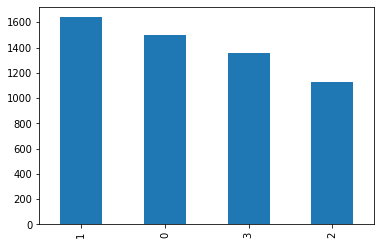

In [123]:
print(df_train.labels.value_counts())
df_train.labels.value_counts().plot.bar()

In [124]:
df_train["count"] = df_train.features.str.count(" ") + 1

Since we only download the short summary, our texts are quite short, since in this dataset we only have the short summary version. Most text have a length of 20-30 words. This means that BERT will most be able to use the full feature text since it has token limit of 512 (510 without padding)

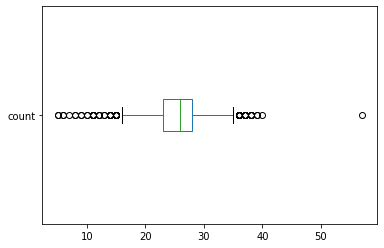

In [125]:
df_train[~df_train["count"].isnull()]["count"].plot(kind="box", vert=False)

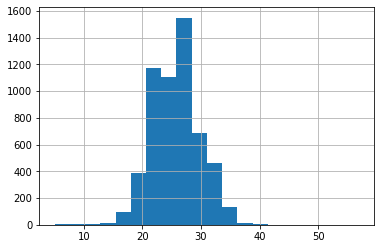

In [126]:
df_train[~df_train["count"].isnull()]["count"].hist(bins=20)

In [127]:
df_train.drop(['count'], axis=1, inplace=True)
df_train.head(1)

,features,labels
1935,corporate strategy office cfo key member of th...,3


**5. Short Analysis df_train_big** ================================================================================================================

In [128]:
df_big_train.head(2)

,features,labels
3452,"vp of retail, usa responsible for the manageme...",3
3732,"brand manager, adult nutrition business unit o...",3


In [129]:
uniques

['entry level', 'internship', 'mid level', 'senior level']

We can see that category 1 (internships) has more examples than the others. However, each category of df_train has at least 1000 instances, which should be good enough for BERT.

0    1106
2    1052
1    1021
3    1013
Name: labels, dtype: int64


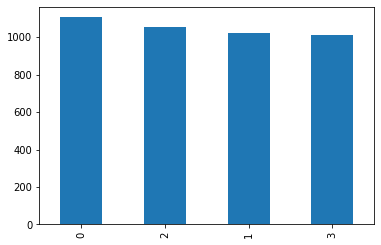

In [130]:
print(df_big_train.labels.value_counts())
df_big_train.labels.value_counts().plot.bar()

In [131]:
df_big_train["count"] = df_big_train.features.str.count(" ") + 1

The word count of the complete summary is much larger, so it is likely that BERT will only see the first part of a text. We could change that, by only using the middle or the end, but in this case we will leave it to read the first 510 tokens, hoping that this will be sufficient.

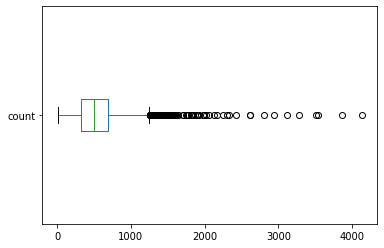

In [132]:
df_big_train[~df_big_train["count"].isnull()]["count"].plot(kind="box", vert=False)

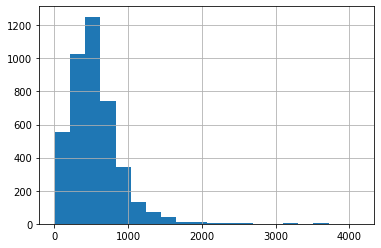

In [133]:
df_big_train[~df_big_train["count"].isnull()]["count"].hist(bins=20)

In [134]:
#df_big_train.drop(['count'], axis=1, inplace=True)
df_big_train.head(5)

,features,labels,count
3452,"vp of retail, usa responsible for the manageme...",3,478
3732,"brand manager, adult nutrition business unit o...",3,758
2399,"purchasing agent salary $70,304.00 - $98,425.6...",2,257
2486,production supervisor (bilingual) summary the ...,2,400
302,production weekender ($33.425/hr) budweiser. b...,0,442


**SVM**

We can try a couple of classic models from scikit first, also to have an additional idea of how well our BERT model performs in comparison, so we have a better estimate than just trying to beat a .25 accuracy, which we would approximately get if we just guessed each class.

In [137]:
#Code from: https://medium.com/swlh/multi-class-text-classification-using-scikit-learn-a9bacb751048
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.naive_bayes import MultinomialNBfrom 
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas  as pd
from io import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [138]:
labels = df.labels

In [139]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                        ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.features).toarray()

In [140]:
len(features)

6253

In [141]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df.features)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [142]:
from sklearn.model_selection import cross_val_score
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          LinearSVC(),#Linear Support Vector Classification.
          LogisticRegression(random_state=0),
         ]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    print("START", model)
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV, n_jobs=-1, verbose=0)
    for fold_idx, accuracy in enumerate(accuracies):
        print("FOLD:", fold_idx)
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

START RandomForestClassifier(max_depth=3, n_estimators=200, random_state=0)
FOLD: 0
FOLD: 1
FOLD: 2
FOLD: 3
FOLD: 4
FOLD: 5
FOLD: 6
FOLD: 7
FOLD: 8
FOLD: 9
START LinearSVC()
FOLD: 0
FOLD: 1
FOLD: 2
FOLD: 3
FOLD: 4
FOLD: 5
FOLD: 6
FOLD: 7
FOLD: 8
FOLD: 9
START LogisticRegression(random_state=0)
FOLD: 0
FOLD: 1
FOLD: 2
FOLD: 3
FOLD: 4
FOLD: 5
FOLD: 6
FOLD: 7
FOLD: 8
FOLD: 9


In [143]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.821062
LogisticRegression        0.823457
RandomForestClassifier    0.648017
Name: accuracy, dtype: float64

In [144]:
uniques

['entry level', 'internship', 'mid level', 'senior level']

In [145]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

On our own test set we can reach accuracies of around .8, which we will hopefully beat with BERT.

In [146]:
print(metrics.classification_report(y_test, y_pred, target_names=uniques))

              precision    recall  f1-score   support

 entry level       0.80      0.82      0.81       544
  internship       1.00      0.99      0.99       604
   mid level       0.62      0.64      0.63       412
senior level       0.82      0.78      0.80       504

    accuracy                           0.83      2064
   macro avg       0.81      0.81      0.81      2064
weighted avg       0.83      0.83      0.83      2064



**7. Abschnitt: BERT - Imports und Funktionen** ================================================================================================================

Schließlich installieren wir Transformers importieren die notwendigen Libraries und bereiten die Funktionen für das Training vor. Wie schon geschrieben beruht der Code vor allem auf McCormicks.

In [147]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 895 kB 44.7 MB/s 
     |████████████████████████████████| 3.3 MB 37.3 MB/s 
     |████████████████████████████████| 61 kB 531 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [148]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [149]:
import time
import datetime
import random
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

In [150]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    #Takes a time in seconds and returns a string hh:mm:ss
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Beim Training gab es verschiedene Herausforderungen. So gibt Colab öfter einen "RuntimeError: CUDA out of memory." aus, bei dem das genaue Problem oftmals unklar ist. Daher wurde einmal eine clean_cuda()-Funktion (unten) erstellt, die nach einigen Trainings ausgeführt wird, um Platz frei zu machen. Da diese das Problem auch nicht immer löst, wurde außerdem nach einer Empfehlung auf Stackoverflow die batch_size verringert (https://stackoverflow.com/questions/59789059/gpu-out-of-memory-error-message-on-google-colab), wobei bei einer batch_size = 8 kaum noch Probleme auftraten. Der Nachteil hierbei ist natürlich, dass dadurch ein Hyperparameter, der eigentlich auf 16 gelassen werden sollte, manipuliert wird. Weiterhin scheint der CUDA Error auch aufzutreten, wenn im Training Set Klassen nicht auftauchen, die im im Validationsset enthalten sind. Daher wurde dafür dieselbe Funktion hinzugefügt, die den Train-Val-Split so oft durchführt, bis die Klassenaufteilung passt, wie schon beim Train Test Split.


In [151]:
#TRAIN FUNCTION
import random
def train_net(df, example_sentence=1, train_split_value=0.9, batch_size = 8, epochs = 3, model_name="bert-base-uncased", lr = 2e-5, eps = 1e-8):

    # The DataLoader needs to know our batch size for training, so we specify it 
    # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
    # size of 16 or 32.
    #batch_size = 16 -> Wir benutzen 8 um CUDA errors zu vermeiden.

  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

  # If there's a GPU available...
  if torch.cuda.is_available():    
      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")
      print('There are %d GPU(s) available.' % torch.cuda.device_count())
      print('We will use the GPU:', torch.cuda.get_device_name(0))
  # If not...
  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  
  # Load the BERT tokenizer.
  print('Loading BERT tokenizer...')
  #choose cased or uncased bert -> uncased without capital letters
  tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
    
  #rename columns (make sure df passed only has two)
  df = df.rename(columns={df.columns[0]: "features", df.columns[1]: "labels"})
  print(df.head())
  
  keep_in_train = False

  #train test split mit randomized random_state search, wo das die validation set labels
  #alle im training set enthalten sind
  while keep_in_train == False:
    i= random.randint(0,1000)
    df_train, df_keep = train_test_split(df, test_size=0.1, random_state=i)
    A = df_train.labels.unique()
    B = df_keep.labels.unique()
    if set(B).issubset(set(A)):
      print("random_state", i, "is good")
      print("Df Train Labels:", df_train.labels.unique(), "Total:", len(df_train.labels.unique()))
      print("Df Keep Labels:", df_keep.labels.unique(), "Total:", len(df_keep.labels.unique()))
      keep_in_train = True

  print("random_state chosen:", i)

  #split df to arrays
  sentences = df_train.features.values
  labels = df_train.labels.values
  print("Sentences:", len(sentences))
  print("Labels:", len(labels))
  print("Batch_size:", batch_size)

  #print example sentences
  # Print the original sentence.
  print(' Original: ', sentences[example_sentence])
  # Print the sentence split into tokens.
  print('Tokenized: ', tokenizer.tokenize(sentences[example_sentence]))
  # Print the sentence mapped to token ids.
  print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[example_sentence])))

  max_len = 0
  # For every sentence...
  for sent in sentences:
      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))
  print('Max sentence length: ', max_len)

  # Tokenize all of the sentences and map the tokens to their word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                           # Sentence to encode.
                          add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                          max_length = 512,               # Pad & truncate all sentences.        
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',          # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  #Print sentence 0, now as a list of IDs.
  #print('Original: ', sentences[0])
  #print('Token IDs:', input_ids[0])

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Create train-validation split.
  # Calculate the number of samples to include in each set.
  
  train_size = int(train_split_value * len(dataset))
  val_size = len(dataset) - train_size

  # Divide the dataset by randomly selecting samples.
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size))

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 

  from transformers import BertForSequenceClassification, AdamW, BertConfig

  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      model_name,   # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = len(labels.unique()),  # The number of output labels--2 for binary classification.
                                          # You can increase this for multi-class tasks.   
      output_attentions = False,          # Whether the model returns attentions weights.
      output_hidden_states = False,       # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.cuda()

  # Get all of the model's parameters as a list of tuples.
  params = list(model.named_parameters())
  print('The BERT model has {:} different named parameters.\n'.format(len(params)))
  print('==== Embedding Layer ====\n')
  for p in params[0:5]:
      print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
  print('\n==== First Transformer ====\n')
  for p in params[5:21]:
      print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
  print('\n==== Output Layer ====\n')
  for p in params[-4:]:
      print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

  # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
  # I believe the 'W' stands for 'Weight Decay fix"
  optimizer = AdamW(model.parameters(),
                    lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = eps # args.adam_epsilon  - default is 1e-8.
                  )

  # Number of training epochs. The BERT authors recommend between 2 and 4. 
  # We chose to run for 4, but we'll see later that this may be over-fitting the
  # training data.
  #epochs = 3

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)

  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================================================
      #                             Training
      # ========================================================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # In PyTorch, calling `model` will in turn call the model's `forward` 
          # function and pass down the arguments. The `forward` function is 
          # documented here: 
          # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
          # The results are returned in a results object, documented here:
          # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

          loss = result.loss
          logits = result.logits

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
      # ========================================================================
      #                             Validation
      # ========================================================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the 
          # output values prior to applying an activation function like the 
          # softmax.
          loss = result.loss
          logits = result.logits
          # Accumulate the validation loss.
          total_eval_loss += loss.item()
          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          
      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))
      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


  # Display floats with two decimal places.
  pd.set_option('precision', 2)
  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=training_stats)
  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')
  # A hack to force the column headers to wrap.
  #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
  # Display the table.
  print(df_stats)

  #=========================PLOT TRAINING LOSS==================================
  # Use plot styling from seaborn.
  sns.set(style='darkgrid')
  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)
  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4])
  plt.show()

  #===========================TEST ON VALIDATION SET============================
  # Load the dataset into a pandas dataframe.
  df = df_keep.copy()
  # Report the number of sentences.
  print('Number of test sentences: {:,}\n'.format(df.shape[0]))
  # Create sentence and label lists
  sentences = df_keep.features.values
  labels = df_keep.labels.values
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          #max_length = 64,           # Pad & truncate all sentences.
                          max_length = 512,   
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  # Prediction on test set
  print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  predictions , true_labels = [], []
  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)

    logits = result.logits
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  print('    DONE.')

  #label_ids

  # Combine the results across all batches. 
  flat_predictions = np.concatenate(predictions, axis=0)
  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  df['predictions'] = flat_predictions

  return df, model, tokenizer


In [152]:
#TEST FUNCTION

def test_net(df_test, model, batch_size = 8):

    # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

  # If there's a GPU available...
  if torch.cuda.is_available():    
      # Tell PyTorch to use the GPU.    
      device = torch.device("cuda")
      print('There are %d GPU(s) available.' % torch.cuda.device_count())
      print('We will use the GPU:', torch.cuda.get_device_name(0))
  # If not...
  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  

  #===========================TEST ON TEST SET============================
  df = df_test.copy()
  df = df.rename(columns={df.columns[0]: "features", df.columns[1]: "labels"})
  print('Number of test sentences: {:,}\n'.format(df.shape[0]))
  sentences = df.features.values
  labels = df.labels.values
  input_ids = []
  attention_masks = []
  for sent in sentences:
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,          # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    ) 
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
  model.eval()
  predictions , true_labels = [], []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)

    logits = result.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)
  print('    DONE.')

  flat_predictions = np.concatenate(predictions, axis=0)
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  flat_true_labels = np.concatenate(true_labels, axis=0)

  df['predictions'] = flat_predictions

  return df, model


In [153]:
#Save Model to Gmail Drive
import os

def save_model(model_name, model, tokenizer):
  output_dir = './drive/MyDrive/model_save/' + model_name + "/"
  # Create output directory if needed
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)
  print("Saving model to %s" % output_dir)
  model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained(output_dir)
  tokenizer.save_pretrained(output_dir)

def load_model(model_name, model, tokenizer):
  output_dir = './drive/MyDrive/model_save/' + model_name + "/"
  model = model.from_pretrained(output_dir)
  tokenizer = tokenizer.from_pretrained(output_dir)
  print(model)
  return model

In [168]:
#classification report better version
from sklearn.metrics import classification_report

def class_report(df, lvl_list):

  uniques = set(list(set(df.labels.sort_values().unique()))+list(set(df.predictions.sort_values().unique())))
  #print(uniques)
  my_list = []
  for i in uniques:
    my_string = str(i) + " " + lvl_list[i]
    my_list.append(my_string)

  print(my_list)
  y_true = df.labels
  print(len(df.labels.unique()))
  y_pred = df.predictions
  print(len(df.predictions.unique()))
  target_names = my_list
  print(len(my_list))
 
  print("Classification Report:")
  print(classification_report(y_true, y_pred, target_names=target_names))

  report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
  return report

In [155]:
#confusion matrix report
#code von: https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def cm_report(df, lvl_list,figsize=(10,5)):

  uniques = set(list(set(df.labels.sort_values().unique()))+list(set(df.predictions.sort_values().unique())))
  print(uniques)
  my_list = []
  for i in uniques:
    my_string = str(i) + " " + lvl_list[i]
    my_list.append(my_string)

  y_test = df.labels
  y_pred = df.predictions
  cm = confusion_matrix(y_test, y_pred)
  cm_df = pd.DataFrame(cm,
                      index = my_list, 
                      columns = my_list)
  plt.figure(figsize=figsize)
  cm_plot = sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues') #'YlGnBu'
  cm_plot
  plt.title('Confusion Matrix:')
  plt.ylabel('Labels')
  plt.xlabel('Predicted')
  plt.show()
  return cm_plot

In [156]:
from sklearn.metrics import f1_score
def just_f1_score(df, average="macro"):
  y_true = df.labels
  y_pred = df.predictions
  result = f1_score(y_true, y_pred, average=average)

  return result

In [157]:
#EMPTY CASH CUDA
import torch, gc
def clean_cuda():
  gc.collect()
  torch.cuda.empty_cache()
  print(torch.cuda.memory_summary(device=None, abbreviated=False))
#clean_cuda()

**8. Abschnitt: BERT - Fine-Tuning and Results** ================================================================================================================

**Training and Test**

We can now fine_tune BERT to compary our prediction level over our own as well as the given validation dataset to be able to estimate how good our predictions are. After 4 epochs we can observe overfitting, so we limit the numer of epochs to 2 while using bert-base-uncased, since from experience, uncased usually performs better then cased and because bert-base is faster than bert-large. (Alternatively we could also use Bert distilled.) On the standard colab account, the notebook tends to crash with batch_size 16 or higher, so we pick a batch_size of 8.

In [158]:
#function variables
#def train_net(df, example_sentence=1, train_split_value=0.9, batch_size = 8, epochs = 3, model_name="bert-base-uncased", lr = 2e-5, eps = 1e-8)

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

                                               features  labels
1935  corporate strategy office cfo key member of th...       3
1450  ma intern - cw lake underhill the intern - gen...       1
1689  engineering intern | aerospace | summer 2022 e...       1
26    deutsche bank dbachieve internship programme –...       1
182   summer 2022 fp&a collections intern this progr...       1
random_state 234 is good
Df Train Labels: [0 2 3 1] Total: 4
Df Keep Labels: [3 2 1 0] Total: 4
random_state chosen: 234
Sentences: 5064
Labels: 5064
Batch_size: 8
 Original:  resource analyst-2 partners with lead program or project resource analyst (pra) to evaluate the work breakdown structure (wbs) ensuring appropriate level of detail, wbs dictionary…
Tokenized:  ['resource', 'analyst', '-', '2', 'partners', 'with', 'lead', 'program', 'or', 'project', 'resource', 'analyst', '(', 'pr', '##a', ')', 'to', 'evaluate', 'the', 'work', 'breakdown', 'structure', '(', 'wb', '##s', ')', 'ensuring', 'appropriate', 'l

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max sentence length:  72


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


4,557 training samples
  507 validation samples


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

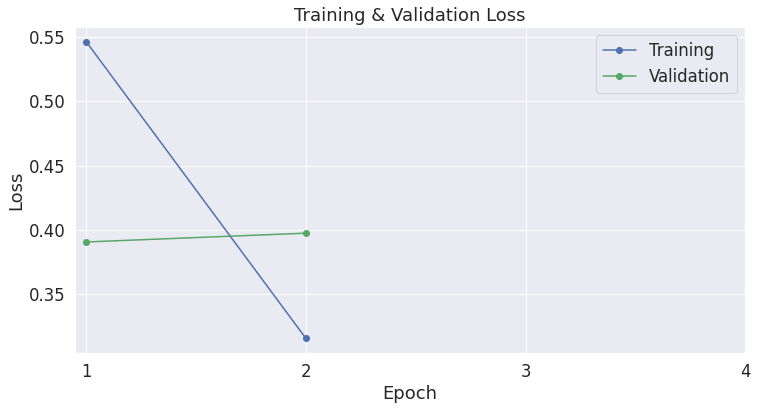

Number of test sentences: 563



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 563 test sentences...
    DONE.


In [160]:
#train model
df_train_res, model, tokenizer = train_net(df=df_train, epochs=1, model_name="bert-base-uncased")
df_train_res.to_csv("./drive/MyDrive/Colab Notebooks/clf/reports/df_smallsum_train_results.csv")

In [166]:
#test the model with df_val from our indeed set
df_test_results, model = test_net(df_val, model)
df_test_results.to_csv("./drive/MyDrive/Colab Notebooks/clf/reports/df_smallsum_val_test_results.csv")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Number of test sentences: 626



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 626 test sentences...
    DONE.


In [169]:
#get classification report
report = class_report(df_test_results, uniques)
df_class_report = pd.DataFrame(report).transpose()
df_class_report.to_excel("./drive/MyDrive/Colab Notebooks/clf/reports/df_smallsum_val_class_rep.xlsx")

['0 entry level', '1 internship', '2 mid level', '3 senior level']
4
4
4
Classification Report:
                precision    recall  f1-score   support

 0 entry level       0.82      0.83      0.82       167
  1 internship       0.99      1.00      1.00       182
   2 mid level       0.66      0.63      0.64       126
3 senior level       0.88      0.89      0.88       151

      accuracy                           0.85       626
     macro avg       0.84      0.84      0.84       626
  weighted avg       0.85      0.85      0.85       626



{0, 1, 2, 3}


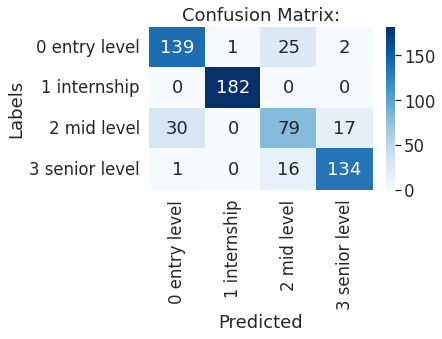

In [167]:
#confusion matrix report
cm_plot = cm_report(df_test_results, uniques, figsize=(5,3))
cm_plot.figure.savefig("./drive/MyDrive/Colab Notebooks/clf/reports/df_smallsum_val_cm.png", bbox_inches = 'tight')

In [170]:
#save the model
model_name = "model_small_sum_f1_weighted.85"
save_model(model_name, model, tokenizer)

Saving model to ./drive/MyDrive/model_save/model_small_sum_f1_weighted.85/


Let's see how our model performs on the provided labelled data set, df_val_data:

In [171]:
#test the model with df_val_data
df_test_results, model = test_net(df_val_data, model)
df_test_results.to_csv("./drive/MyDrive/Colab Notebooks/clf/reports/df_smallsum_val_data_test_results.csv")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Number of test sentences: 141



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 141 test sentences...
    DONE.


The performance on the given val_set from data.json is much worse, even though the f1-scores for internship is still good, however for senior level it is only .66 and only .22 and .31 for entry and mid level. The confusion matrix also shows that our model falsely classifies entry and mid level jobs as senior jobs.

In [172]:
#get classification report
report = class_report(df_test_results, uniques)

df_class_report = pd.DataFrame(report).transpose()
df_class_report.to_excel("./drive/MyDrive/Colab Notebooks/clf/reports/df_smallsum_val_data_class_rep.xlsx")

['0 entry level', '1 internship', '2 mid level', '3 senior level']
4
4
4
Classification Report:
                precision    recall  f1-score   support

 0 entry level       0.62      0.14      0.22        37
  1 internship       0.93      0.87      0.90        15
   2 mid level       0.33      0.28      0.31        32
3 senior level       0.53      0.86      0.66        57

      accuracy                           0.54       141
     macro avg       0.60      0.54      0.52       141
  weighted avg       0.55      0.54      0.49       141



{0, 1, 2, 3}


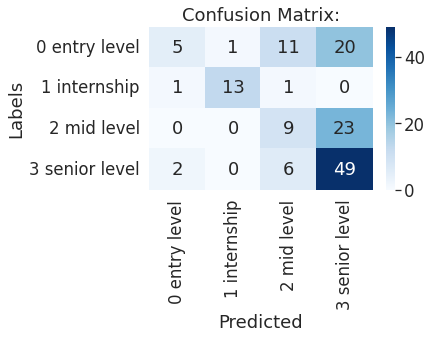

In [173]:
#confusion matrix report
cm_plot = cm_report(df_test_results, uniques, figsize=(5,3))
cm_plot.figure.savefig("./drive/MyDrive/Colab Notebooks/clf/reports/df_smallsum_val_data_cm.png", bbox_inches = 'tight')

In [174]:
df_test_results["label_names"] = np.nan
for i in range(len(df_test_results)):
  df_test_results.loc[i, "label_names"] = uniques[df_test_results.iloc[i]["labels"]]

df_test_results["prediction_names"] = np.nan
for i in range(len(df_test_results)):
  df_test_results.loc[i, "prediction_names"] = uniques[df_test_results.iloc[i]["predictions"]]

We can check df_data_val a but more closely, namels looks at the instances were entry and mid level were wrongly classified as senior level. The feature with index = 0 was in a prior tuning misclassified as "senior level", however, when we read the job description it is not obivious that the label 0 is actually correct, since 3+ years might be considered mid level. The short descriptions of our training dataset might be responsible for this lack of generalization here. Fortunately, we also have a training data set with long summaries, and can try this out subsequently. If we assumed that the df_val_data is correctly labeled, we can expect an F1-Score over the set we have to predict of around .52, which is not great.

In [176]:
df_test_results[ (df_test_results["labels"] == 0) & (df_test_results["predictions"] == 3) |
                 (df_test_results["labels"] == 2) & (df_test_results["predictions"] == 3) 
               ]

,features,labels,predictions,label_names,prediction_names
2,android developer job description pamet is loo...,0,3,entry level,senior level
4,ibm websphere portal developer job description...,0,3,entry level,senior level
5,ios developer job description pamet is looking...,0,3,entry level,senior level
6,java developer job description pamet is lookin...,0,3,entry level,senior level
11,infrastructure engineer (aws) descriptionwe ar...,2,3,mid level,senior level
13,frontend engineer (full-stack) descriptionwe a...,2,3,mid level,senior level
19,ui/ux designer the role: we’re looking for a t...,2,3,mid level,senior level
34,customer success manager (remote) descriptioni...,0,3,entry level,senior level
37,software developer - javascript (cross-platfor...,2,3,mid level,senior level
39,"trust & safety manager, india the uber trust &...",0,3,entry level,senior level


In [177]:
#predict the empty dataset
df_pred_data["title"] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [178]:
df_test_results, model = test_net(df_pred_data, model)

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Number of test sentences: 75



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 75 test sentences...
    DONE.


In [179]:
df_predicted = df_test_results[["features", "predictions"]]

In [180]:
df_predicted

,features,predictions
141,customer service netherlands in berlin (m/f) o...,0
142,devops engineer (m/f) outfittery is europe’s b...,3
143,head of product management (it) (m/f) outfitte...,3
144,help desk support (m/f) outfittery is europe’s...,2
145,intern help desk (m/f) outfittery is europe’s ...,1
...,...,...
211,native italian translation internship work in ...,1
212,international translation internship program (...,1
213,photography - new york habitat internship phot...,1
214,high paying part time delivery driver are you ...,0


In [181]:
df_predicted.to_csv("./drive/MyDrive/Colab Notebooks/clf/df_predicted_small_f1_weighted.49.csv")

**Try with Big Indeed Dataset**

In [182]:
#function variables
#def train_net(df, example_sentence=1, train_split_value=0.9, batch_size = 8, epochs = 3, model_name="bert-base-uncased", lr = 2e-5, eps = 1e-8)

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Loading BERT tokenizer...


Token indices sequence length is longer than the specified maximum sequence length for this model (871 > 512). Running this sequence through the model will result in indexing errors


                                               features  labels  count
3452  vp of retail, usa responsible for the manageme...       3    478
3732  brand manager, adult nutrition business unit o...       3    758
2399  purchasing agent salary $70,304.00 - $98,425.6...       2    257
2486  production supervisor (bilingual) summary the ...       2    400
302   production weekender ($33.425/hr) budweiser. b...       0    442
random_state 654 is good
Df Train Labels: [1 2 0 3] Total: 4
Df Keep Labels: [0 3 1 2] Total: 4
random_state chosen: 654
Sentences: 3772
Labels: 3772
Batch_size: 8
 Original:  recruiting coordinator who we are founded in 2013, thistle’s mission is to empower our customers to get and stay healthy while improving the sustainability of our food system. we deliver delicious, organic, healthy, plant-forward meals, cold-pressed juices, and snacks to customers on the west coast who want to put their nutrition on auto-pilot. we don’t want to be just another food delivery star

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max sentence length:  5301


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


3,394 training samples
  378 validation samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

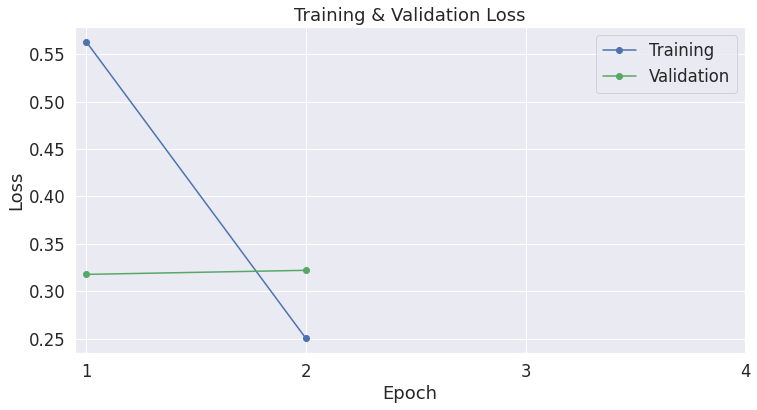

Number of test sentences: 420



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 420 test sentences...
    DONE.


In [183]:
#train model
df_train_res, model, tokenizer = train_net(df=df_big_train, epochs=2, model_name="bert-base-uncased")
df_model = model

In [184]:
#test the model with df_val from our indeed set
df_test_results, model = test_net(df_big_val, model)
df_test_results.to_csv("./drive/MyDrive/Colab Notebooks/clf/reports/df_big_val_test_results.csv")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Number of test sentences: 466



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 466 test sentences...
    DONE.


The model trained on long indeed summaries performs much better and reaches accuracy and f1 scores of .9 on its on validation set. Here, too, the model has most difficulties deciding between adjacent classes, which makes sense.

In [185]:
#get classification report
report = class_report(df_test_results, uniques)

df_class_report = pd.DataFrame(report).transpose()
df_class_report.to_excel("./drive/MyDrive/Colab Notebooks/clf/reports/df_big_val_class_rep.xlsx")

['0 entry level', '1 internship', '2 mid level', '3 senior level']
4
4
4
Classification Report:
                precision    recall  f1-score   support

 0 entry level       0.93      0.91      0.92       123
  1 internship       0.98      1.00      0.99       114
   2 mid level       0.82      0.79      0.81       117
3 senior level       0.88      0.91      0.89       112

      accuracy                           0.90       466
     macro avg       0.90      0.90      0.90       466
  weighted avg       0.90      0.90      0.90       466



{0, 1, 2, 3}


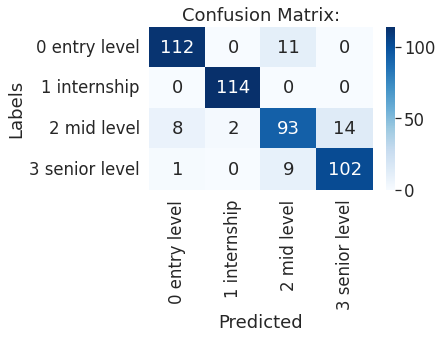

In [186]:
#confusion matrix report
cm_plot = cm_report(df_test_results, uniques, figsize=(5,3))
cm_plot.figure.savefig("./drive/MyDrive/Colab Notebooks/clf/reports/df_big_val_cm.png", bbox_inches = 'tight')

In [189]:
#save the model
model_name = "model_big_sum_f1_weighted_.90"
save_model(model_name, model, tokenizer)

Saving model to ./drive/MyDrive/model_save/model_big_sum_f1_weighted_.90/


Let's see how our model performs on the provided labelled data set, df_val_data:

In [190]:
#test the model with df_val_data
df_test_results, model = test_net(df_val_data, model)
df_test_results.to_csv("./drive/MyDrive/Colab Notebooks/clf/reports/df_big_val_data_test_results.csv")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Number of test sentences: 141



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 141 test sentences...
    DONE.


The performance is again significantly worse, even though the f1-scores for internship is still good, and teaches an overal f1 weighted of .6. We can therefore assume that our predictions would achieve an f1-score of about .6. From the confusion matric we can see that the problem has more difficulties chosing between adjacent classes, e.g. entry and mid level or mid and senior level which makes sense. It has an easy time finding internship instances, however, these seem to be particularly well defined by certain keywords such as "intern" or "internship".

In [191]:
#get classification report
report = class_report(df_test_results, uniques)

df_class_report = pd.DataFrame(report).transpose()
df_class_report.to_excel("./drive/MyDrive/Colab Notebooks/clf/reports/df_big_val_data_class_rep.xlsx")

['0 entry level', '1 internship', '2 mid level', '3 senior level']
4
4
4
Classification Report:
                precision    recall  f1-score   support

 0 entry level       0.67      0.27      0.38        37
  1 internship       0.94      1.00      0.97        15
   2 mid level       0.40      0.62      0.49        32
3 senior level       0.70      0.74      0.72        57

      accuracy                           0.62       141
     macro avg       0.68      0.66      0.64       141
  weighted avg       0.65      0.62      0.60       141



{0, 1, 2, 3}


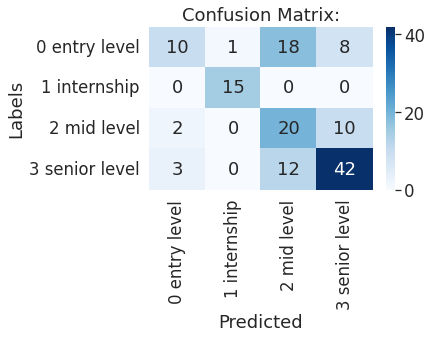

In [192]:
#confusion matrix report
cm_plot = cm_report(df_test_results, uniques, figsize=(5,3))
cm_plot.figure.savefig("./drive/MyDrive/Colab Notebooks/clf/reports/df_big_val_data_cm.png", bbox_inches = 'tight')

In [193]:
df_test_results["label_names"] = np.nan
for i in range(len(df_test_results)):
  df_test_results.loc[i, "label_names"] = uniques[df_test_results.iloc[i]["labels"]]

df_test_results["prediction_names"] = np.nan
for i in range(len(df_test_results)):
  df_test_results.loc[i, "prediction_names"] = uniques[df_test_results.iloc[i]["predictions"]]

Again, in some mislabelled cases, one could argue that the model actually labeled better than what the original label was, such as at index 0 (already mentioned before. In other cases it clearly labelled wrong ("junior manager" as senior at 121.

In [194]:
df_test_results[ (df_test_results["labels"] == 0) & (df_test_results["predictions"] == 2) |
                 (df_test_results["labels"] == 2) & (df_test_results["predictions"] == 3) |
                 (df_test_results["labels"] == 0) & (df_test_results["predictions"] == 3) 
               ]

,features,labels,predictions,label_names,prediction_names
0,frontend engineer (m/f) outfittery is europe’s...,0,2,entry level,mid level
4,ibm websphere portal developer job description...,0,2,entry level,mid level
6,java developer job description pamet is lookin...,0,3,entry level,senior level
13,frontend engineer (full-stack) descriptionwe a...,2,3,mid level,senior level
23,backend geek company descriptiontripigator is ...,0,2,entry level,mid level
26,staff accountant job purpose: ensure all fin...,0,2,entry level,mid level
34,customer success manager (remote) descriptioni...,0,2,entry level,mid level
39,"trust & safety manager, india the uber trust &...",0,3,entry level,senior level
46,customer success representative (indonesia ter...,0,2,entry level,mid level
47,"account manager, indonesia territory (based in...",2,3,mid level,senior level


In [195]:
#predict the empty dataset
df_pred_data["title"] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [196]:
df_test_results, model = test_net(df_pred_data, model)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Number of test sentences: 75

Predicting labels for 75 test sentences...
    DONE.


In [197]:
df_predicted = df_test_results[["features", "predictions"]]

In [198]:
df_predicted

,features,predictions
141,customer service netherlands in berlin (m/f) o...,0
142,devops engineer (m/f) outfittery is europe’s b...,3
143,head of product management (it) (m/f) outfitte...,3
144,help desk support (m/f) outfittery is europe’s...,0
145,intern help desk (m/f) outfittery is europe’s ...,1
...,...,...
211,native italian translation internship work in ...,1
212,international translation internship program (...,1
213,photography - new york habitat internship phot...,1
214,high paying part time delivery driver are you ...,0


In [199]:
df_predicted.to_csv("./drive/MyDrive/Colab Notebooks/clf/df_predicted_big_f1_weighted.6.csv")

**Try with Val_Data Set**

We can also try using the given dataset, however, it is so small that it is unlikely we will have much success with it and we only reach accuracies of .41. In the training and subsequently have no real validation set. Even using the already seen data as a validation set (which shouldn't be done), leads to worse results then we reached before.

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Loading BERT tokenizer...


Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors


                                            features  labels
0  frontend engineer (m/f) outfittery is europe’s...       0
1  senior product manager (m/f) outfittery is eur...       3
2  android developer job description pamet is loo...       0
3  development lead we are looking for a developm...       3
4  ibm websphere portal developer job description...       0
random_state 25 is good
Df Train Labels: [2 3 1 0] Total: 4
Df Keep Labels: [1 0 3 2] Total: 4
random_state chosen: 25
Sentences: 126
Labels: 126
Batch_size: 8
 Original:  manager, integrated marketing, vh1-velocity - develop creative multi-platform integrated marketing programs for various vh1 properties including awards shows and vh1 original programming. - work with the linear production and digital site teams to create multi-platform, linear, and digital only sponsorship packages for assigned spike properties. - oversee day-to-day execution of sponsorship elements after sell-in for assigned vh1 properties. - work closely w

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max sentence length:  1210


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  100 training samples
   26 validation samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

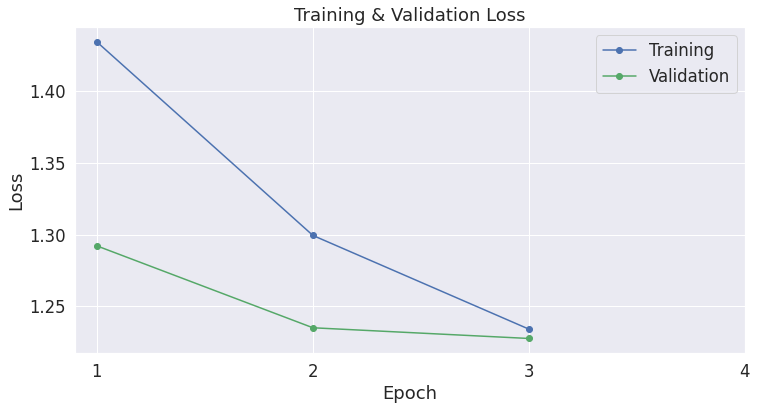

Number of test sentences: 15

Predicting labels for 15 test sentences...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


    DONE.


In [216]:
#train model
df_train_res, model, tokenizer = train_net(df=df_val_data, train_split_value=0.8, epochs=2, model_name="bert-base-uncased")
df_val_model = model

In [217]:
df_test_results, model = test_net(df_val_data, model)

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Number of test sentences: 141



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 141 test sentences...
    DONE.


As expected, the results are not good and the model is clearly biased towards classifying instances as senior level, probably also because the support of this level is much higher.

In [218]:
#get classification report
report = class_report(df_test_results, uniques)

df_class_report = pd.DataFrame(report).transpose()

['0 entry level', '1 internship', '2 mid level', '3 senior level']
4
3
4
Classification Report:
                precision    recall  f1-score   support

 0 entry level       0.53      0.24      0.33        37
  1 internship       0.00      0.00      0.00        15
   2 mid level       0.73      0.25      0.37        32
3 senior level       0.50      0.98      0.66        57

      accuracy                           0.52       141
     macro avg       0.44      0.37      0.34       141
  weighted avg       0.50      0.52      0.44       141



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

{0, 1, 2, 3}


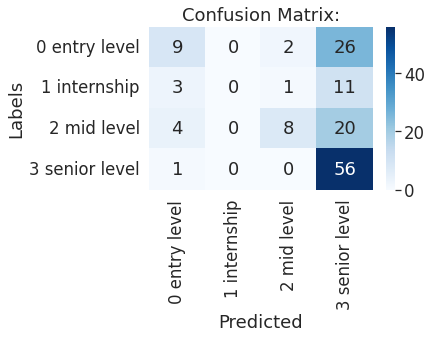

In [219]:
#confusion matrix report
cm_plot = cm_report(df_test_results, uniques, figsize=(5,3))

**Export Notebook zu HTML**

In [1]:
#convert ipynb to html
%%shell
jupyter nbconvert --to html /content/clf_bert.ipynb

SyntaxError: invalid syntax (Temp/ipykernel_12364/3029411823.py, line 3)